# Global Analysis Pipeline

## Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import math
pd.set_option('display.max_columns', None)

## Global variables / settings for this notebook

In [2]:
# subject-independant directory and filename of raw-data
input_subject_folder = f"..\\data\\preprocessed\\"
# path to stimuli of experiment
exp_stimuli_folder = "..\\stimuli\\"
# set global colormap var
cmp = plt.cm.viridis_r
# display resolution
display = {"width": 1920, "height": 1080}
# Define the folder name
plt_folder_name = f'..\\plots\\global'# Define the global folder name

In [3]:
# enter subject id of participants you want to include in the global analysis 
global_analysis_subjects = [1, 3, 5, 7, 9, 2, 4, 6, 8, 10]

In [4]:
subj_list = []
for subj in global_analysis_subjects:
    subj_list.append(f"subject-{subj}.tsv")


dframes_list = []
for filename in subj_list:
    df = pd.read_csv(input_subject_folder + filename, sep="\t", header=0)
    dframes_list.append(df)

data = pd.concat(dframes_list, axis=0, ignore_index=True)

In [5]:
# round to 3 decimals helper function
def dround(number:float):
    return round(number, 3)

## Global Analysis

### Analysis of individual sentences

In [6]:
def bpog_in_target_bbox(bpogx, bpogy, pos):

    width = display["width"]
    height = display["height"]

    x = bpogx * width
    y = bpogy * height
    
    if pos == "TL":
        relpos = (width/4, height/4)
    elif pos == "TR":
        relpos = (width*(3/4), height/4)
    elif pos == "BL":
        relpos = (width/4, height*(3/4))
    elif pos == "BR":
        relpos = (width*(3/4), height*(3/4))
    else:
        relpos = -1

    pos_x_l = relpos[0] - 200
    pos_x_r = relpos[0] + 200
    pos_y_d = relpos[1] - 200
    pos_y_u = relpos[1] + 200

    if (x > pos_x_l) and (x < pos_x_r):
        if(y > pos_y_d) and (y < pos_y_u):
            return True

    return False


def get_bounding_box_coords(pos):
    
    relpos = 0    
    width = display["width"]
    height = display["height"]


    if pos == "TL":
        relpos = (width/4, height/4)
    elif pos == "TR":
        relpos = (width*(3/4), height/4)
    elif pos == "BL":
        relpos = (width/4, height*(3/4))
    elif pos == "BR":
        relpos = (width*(3/4), height*(3/4))
    else:
        relpos = -1

    pos_x_l = relpos[0] - 200
    pos_x_r = relpos[0] + 200
    pos_y_d = relpos[1] - 200
    pos_y_u = relpos[1] + 200
    
    return (pos_x_l, pos_x_r, pos_y_d, pos_y_u)

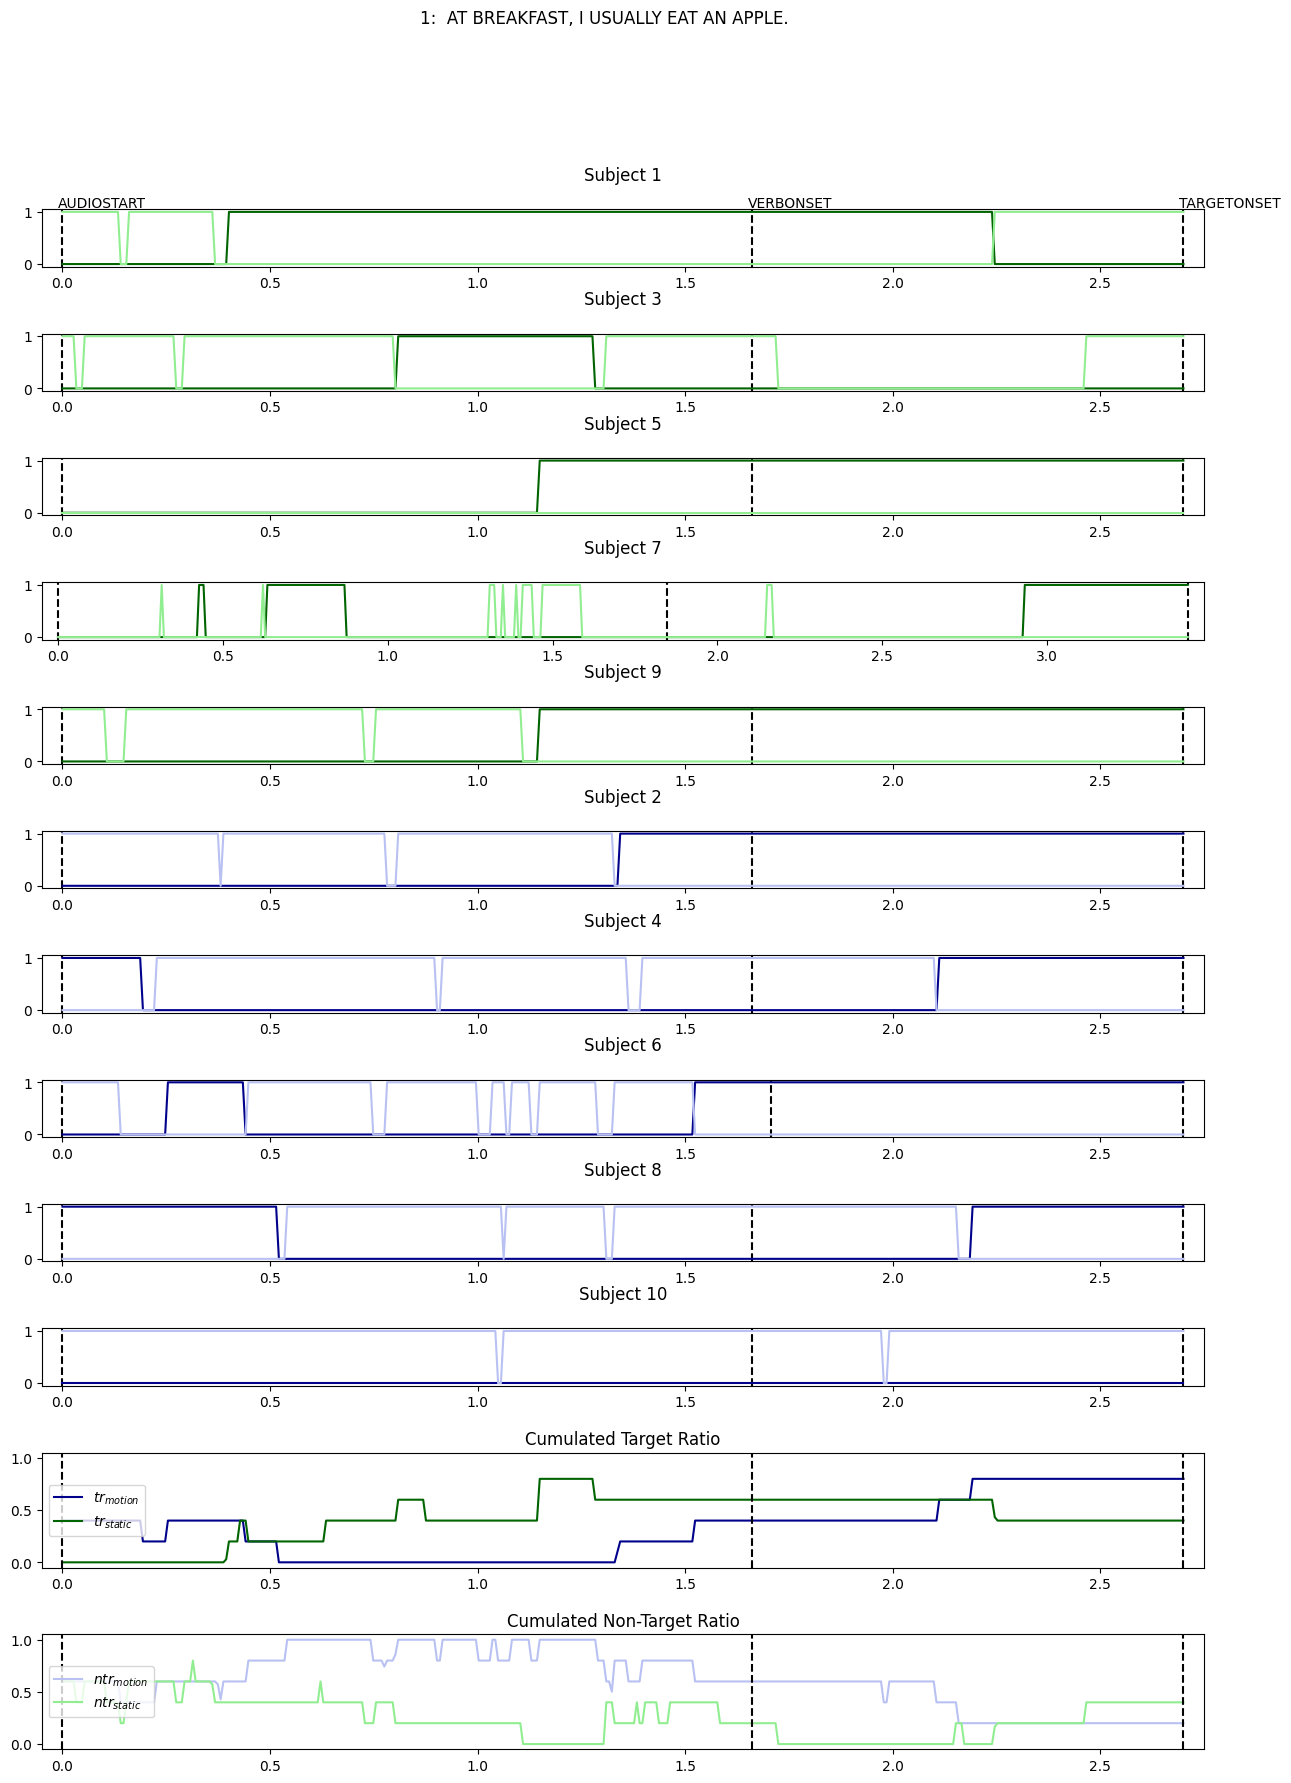

In [7]:
def calc_tr_ntr(data, highlight, sentence_id):

    # init variables
    ratios = [1] * len(global_analysis_subjects)
    ratios.append(2)
    ratios.append(2)

    # get samples with specific id
    data_subset = data.query(f"SENTENCE_ID=={sentence_id}")
    data_subset = data_subset.query(f"EVENT=='AUDIOSTART' or EVENT=='VERBONSET' or EVENT=='TARGETONSET'")

    # filter invalid samples
    data_subset = data_subset.query("BPOGX>=0 and BPOGY >=0")
    data_subset = data_subset.reset_index(drop=True)
    
    # get first row of dataframe
    first_row = data_subset.iloc[0]

    # get general information
    stc = first_row["SENTENCE"]
    t_pos = first_row["TARGET_POS"]
    
    # determin other AOIs
    all_t_pos = ["TL", "TR", "BL", "BR"]
    all_t_pos.remove(t_pos)

    # set tr/ntr for each row
    for index, row in data_subset.iterrows():

        x = row["BPOGX"]
        y = row["BPOGY"]
        in_b_box = bpog_in_target_bbox(x, y, t_pos)
        in_b_box_other = bpog_in_target_bbox(x, y, all_t_pos[0]) or bpog_in_target_bbox(x, y,  all_t_pos[1]) or bpog_in_target_bbox(x, y,  all_t_pos[2])
        
        if in_b_box:
            data_subset.at[index, "TR"] = int(1)
            data_subset.at[index, "NTR"] = int(0)
        else:
            data_subset.at[index, "TR"] = int(0)
            if in_b_box_other:
                data_subset.at[index, "NTR"] = int(1)
            else:
                data_subset.at[index, "NTR"] = int(0)

    # fig 
    fig, ax = plt.subplots(len(global_analysis_subjects)+2, 1, figsize=(15, 20), height_ratios=ratios)
    fig.subplots_adjust(hspace=1)
    
    # subplots
    li = len(global_analysis_subjects)
    for i in range(0, len(global_analysis_subjects)):
        
        subj_no = global_analysis_subjects[i]
        subj_data = data_subset.query(f"SUBJECT=={subj_no}")
        subj_condition = subj_data.query("EVENT=='AUDIOSTART'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "CONDITION"].lower()

        subj_audiostart = subj_data.query("EVENT=='AUDIOSTART'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "TIME"]
        subj_verbonset = subj_data.query(f"EVENT=='VERBONSET'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "TIME"] - subj_audiostart
        subj_targetonset = subj_data.query(f"EVENT=='TARGETONSET'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "TIME"] - subj_audiostart
        
        # normalize time for each subject
        for index, row in subj_data.iterrows():
            subj_data.at[index, "TIME"] -= subj_audiostart
            data_subset.at[index, "TIME"] -= subj_audiostart

        # plot subplots for each participant
        ax[i].set_title(f"Subject {subj_no}\n")
        
        ax[i].axvline(x = 0, linestyle='--', color = 'grey' if 'a' in highlight else 'k')
        ax[i].axvline(x = subj_verbonset, linestyle='--', color = 'grey' if 'a' in highlight else 'k')
        ax[i].axvline(x = subj_targetonset, linestyle='--', color = 'grey' if 'a' in highlight else 'k')

        # interpolation necessary because bpogv filters out some samples
        interp_func_tr = interp1d(subj_data['TIME'], subj_data['TR'], kind='linear', fill_value='interpolate')
        interp_func_ntr = interp1d(subj_data['TIME'], subj_data['NTR'], kind='linear', fill_value='interpolate')
        
        lin_num = (subj_targetonset * 150).round(0).astype(int)
        time = np.linspace(0, subj_targetonset, num=lin_num)

        temdf = pd.DataFrame({})
        temdf['TIME'] = time
        temdf['TR'] = interp_func_tr(time).round(0).astype(int)
        temdf['NTR'] = interp_func_ntr(time).round(0).astype(int)
        
        ax[i].plot(temdf["TIME"], temdf["TR"], label=f"$tr_{subj_condition[0]}$", color = "darkgreen" if subj_condition == "static" else "darkblue")
        ax[i].plot(temdf["TIME"], temdf["NTR"], label=f"$ntr_{subj_condition[0]}$", color = "lightgreen" if subj_condition == "static" else "#b8c1f2")

        ax[i].set_xlim((-.05, subj_targetonset+.05))
    
    # text cuenames
    ax[0].text(-0.01, 1.08, 'AUDIOSTART', color = 'grey' if 'a' in highlight else 'k')
    ax[0].text(subj_verbonset-0.01, 1.08, 'VERBONSET', color = 'grey' if 'v' in highlight else 'k')
    ax[0].text(subj_targetonset-0.01, 1.08, 'TARGETONSET', color = 'grey' if 't' in highlight else 'k')

    # final dfs
    static = pd.DataFrame({})
    static_num = 0
    motion = pd.DataFrame({})
    motion_num = 0
    for i in range(0, len(global_analysis_subjects)):
        
        subj_no = global_analysis_subjects[i]
        subj_data = data_subset.query(f"SUBJECT=={subj_no}").copy()
        subj_condition = subj_data.sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "CONDITION"].lower()
        end = subj_data.query("EVENT=='TARGETONSET'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "TIME"]

        # interpolation necessary because bpogv filters out some samples
        interp_func_tr = interp1d(subj_data['TIME'], subj_data['TR'], kind='linear', fill_value='interpolate')
        interp_func_ntr = interp1d(subj_data['TIME'], subj_data['NTR'], kind='linear', fill_value='interpolate')
        
        lin_num = (end * 150).round(0).astype(int)

        time = np.linspace(0, end, num=lin_num)

        if subj_condition == "motion":
            
            if motion.empty:
                motion['TIME'] = time
                motion['TR'] = interp_func_tr(time)
                motion['NTR'] = interp_func_ntr(time)
            else:
                for index, row in motion.iterrows():
                    motion.at[index, "TR"] += interp_func_tr(row["TIME"]).round(0).astype(int)
                    motion.at[index, "NTR"] += interp_func_ntr(row["TIME"]).round(0).astype(int)
            motion_num += 1

        elif subj_condition == "static":

            if static.empty:
                static['TIME'] = time
                static['TR'] = interp_func_tr(time)
                static['NTR'] = interp_func_ntr(time)
            else:
                for index, row in static.iterrows():
                    static.at[index, "TR"] += interp_func_tr(row["TIME"]).round(0).astype(int)
                    static.at[index, "NTR"] += interp_func_ntr(row["TIME"]).round(0).astype(int)
            static_num += 1
    
    # cummulated plot tr
    ax[li].set_title(f"Cumulated Target Ratio")
    
    ax[li].plot(motion["TIME"], motion["TR"]/motion_num, label="$tr_{motion}$", color = "darkblue")
    ax[li].plot(static["TIME"], static["TR"]/static_num, label="$tr_{static}$", color = "darkgreen")
    
    ax[li].axvline(x = 0, linestyle='--', color = 'grey' if 'a' in highlight else 'k')
    ax[li].axvline(x = subj_verbonset, linestyle='--', color = 'grey' if 'a' in highlight else 'k')
    ax[li].axvline(x = subj_targetonset, linestyle='--', color = 'grey' if 'a' in highlight else 'k')
    ax[li].set_xlim((-.05, subj_targetonset+.05))
    ax[li].set_ylim((-0.05,1.05))
    ax[li].legend(loc="center left")
    
    # cummulated plot ntr
    ax[li+1].set_title(f"Cumulated Non-Target Ratio")
    
    ax[li+1].plot(motion["TIME"], motion["NTR"]/motion_num, label="$ntr_{motion}$", color = "#b8c1f2")
    ax[li+1].plot(static["TIME"], static["NTR"]/static_num, label="$ntr_{static}$", color = "lightgreen")
    
    ax[li+1].axvline(x = 0, linestyle='--', color = 'grey' if 'a' in highlight else 'k')
    ax[li+1].axvline(x = subj_verbonset, linestyle='--', color = 'grey' if 'a' in highlight else 'k')
    ax[li+1].axvline(x = subj_targetonset, linestyle='--', color = 'grey' if 'a' in highlight else 'k')
    ax[li+1].set_xlim((-.05, subj_targetonset+.05))
    ax[li+1].set_ylim((-0.05,1.05))
    ax[li+1].legend(loc="center left")
    
    fig.suptitle(f"{sentence_id}: {stc}")

    plt.show()

    # save plot to assets
    fig.savefig(f'{plt_folder_name}/4-analysis-metrics_{str(sentence_id)}.png')


calc_tr_ntr(data, "", 1)

### Analysis of tr/ntr

##

In [8]:
def calc_tr_ntr_subj(data, subject_no):


    # get samples for user
    data_subset = data.query(f"SUBJECT=={subject_no}")
    # print(subject_no)
    data_subset = data_subset.query(f"EVENT=='AUDIOSTART' or EVENT=='VERBONSET' or EVENT=='TARGETONSET'")
    
    # filter invalid samples
    data_subset = data_subset.query("BPOGX>=0 and BPOGY >=0") 
    data_subset = data_subset.reset_index(drop=True)

    # set tr/ntr for each row
    for index, row in data_subset.iterrows():
        
        # get target pos for each sample
        t_pos = row["TARGET_POS"]
        
        # determin other AOIs
        all_t_pos = ["TL", "TR", "BL", "BR"]
        all_t_pos.remove(t_pos)

        x = row["BPOGX"]
        y = row["BPOGY"]
        in_b_box = bpog_in_target_bbox(x, y, t_pos)
        in_b_box_other = bpog_in_target_bbox(x, y, all_t_pos[0]) or bpog_in_target_bbox(x, y,  all_t_pos[1]) or bpog_in_target_bbox(x, y,  all_t_pos[2])

        if in_b_box:
            data_subset.at[index, "TR"] = int(1)
            data_subset.at[index, "NTR"] = int(0)
        else:
            data_subset.at[index, "TR"] = int(0)
            if in_b_box_other:
                data_subset.at[index, "NTR"] = int(1)
            else:
                data_subset.at[index, "NTR"] = int(0)
        
    
    tr_static_cummul = 0
    ntr_static_cummul = 0
    
    tr_motion_cummul = 0
    ntr_motion_cummul = 0

    for sentence_id in range(1, 64+1):

        # print(f"SENTENCE {sentence_id}")

        # print analysis for subject
        stc_data = data_subset.query(f"SENTENCE_ID=={sentence_id}")
        
        subj_condition = stc_data.query("EVENT=='AUDIOSTART'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "CONDITION"].lower()
        # print(f"Analysis for sentence \"{sentence_id}\" ({subj_condition}) for subject {subject_no}")
        
        subj_audiostart = stc_data.query("EVENT=='AUDIOSTART'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "TIME"]
        subj_targetonset = stc_data.query(f"EVENT=='TARGETONSET'").sort_values(by="TIME", ascending=True).reset_index(drop=True).loc[0, "TIME"] - subj_audiostart
        
        # normalize time for each subject
        for index, row in stc_data.iterrows():
            stc_data.at[index, "TIME"] -= subj_audiostart
            data_subset.at[index, "TIME"] -= subj_audiostart
        
        # interpolation necessary because bpogv filters out some samples
        interp_func_tr = interp1d(stc_data['TIME'], stc_data['TR'], kind='linear', fill_value='interpolate')
        interp_func_ntr = interp1d(stc_data['TIME'], stc_data['NTR'], kind='linear', fill_value='interpolate')
        
        interest_sample = subj_targetonset - 0.05 # 50 ms
        
        if subj_condition == "static":
            tr_static_cummul += interp_func_tr(interest_sample).round(0).astype(int)
            ntr_static_cummul += interp_func_ntr(interest_sample).round(0).astype(int)
        elif subj_condition == "motion":
            tr_motion_cummul += interp_func_tr(interest_sample).round(0).astype(int)
            ntr_motion_cummul += interp_func_ntr(interest_sample).round(0).astype(int)
            

    tr_s = tr_static_cummul/32
    tr_m = tr_motion_cummul/32
    
    ntr_s = ntr_static_cummul/32
    ntr_m = ntr_motion_cummul/32
    
    return (tr_s, tr_m, ntr_s, ntr_m)

In [9]:
rws = []

for i in range(0, len(global_analysis_subjects)):
    subj_no = global_analysis_subjects[i]
    subj_str = f"subject-{subj_no}"
    
    tr_s, tr_m, ntr_s, ntr_m = calc_tr_ntr_subj(data, subj_no)

    rws.append({
        "SUBJECT": subj_no,
        "TR": tr_s,
        "NTR": ntr_s,
        "Condition": "static"
    })

    rws.append({
        "SUBJECT": subj_no,
        "TR": tr_m,
        "NTR": ntr_m,
        "Condition": "motion"
    })

metrics = pd.DataFrame(rws)
metrics


,SUBJECT,TR,NTR,Condition
0,1,0.43750,0.43750,static
1,1,0.62500,0.34375,motion
2,3,0.50000,0.40625,static
3,3,0.37500,0.62500,motion
4,5,0.84375,0.03125,static
5,5,0.75000,0.09375,motion
6,7,0.37500,0.06250,static
7,7,0.40625,0.15625,motion
8,9,0.96875,0.03125,static
9,9,0.84375,0.15625,motion


### Metrics sanity check

TR + NTR should not be greater than 1.

In [22]:
metrics_check = metrics.copy()
metrics_check["TR+NTR"] = metrics_check["TR"] + metrics_check["NTR"]
metrics_check

,SUBJECT,TR,NTR,Condition,TR+NTR
0,1,0.43750,0.43750,static,0.87500
1,1,0.62500,0.34375,motion,0.96875
2,3,0.50000,0.40625,static,0.90625
3,3,0.37500,0.62500,motion,1.00000
4,5,0.84375,0.03125,static,0.87500
5,5,0.75000,0.09375,motion,0.84375
6,7,0.37500,0.06250,static,0.43750
7,7,0.40625,0.15625,motion,0.56250
8,9,0.96875,0.03125,static,1.00000
9,9,0.84375,0.15625,motion,1.00000


### Mean of tr / ntr

In [10]:
stat_tr_dset = metrics.query("Condition=='static'")
mean_s = stat_tr_dset["TR"].mean()
print("TR(statc) mean: ", dround(mean_s))
mean_s = stat_tr_dset["NTR"].mean()
print("NTR(statc) mean: ", dround(mean_s))

print("")

mot_tr_dset = metrics.query("Condition=='motion'")
mean_m = mot_tr_dset["TR"].mean()
print("TR(motion) mean: ", dround(mean_m))
mean_m = mot_tr_dset["NTR"].mean()
print("NTR(motion) mean: ", dround(mean_m))

TR(statc) mean:  0.594
NTR(statc) mean:  0.275

TR(motion) mean:  0.559
NTR(motion) mean:  0.353


### Standard-deviation of tr / ntr

In [11]:
# TR
# stdev static
N = len(stat_tr_dset["TR"])
d2 = abs(stat_tr_dset["TR"] - mean_s)**2
var = d2.sum() / (N)
std = var**0.5
print("TR stdev(static):", dround(std))

# stdev motion
N = len(mot_tr_dset["TR"])
d2 = abs(mot_tr_dset["TR"] - mean_m)**2
var = d2.sum() / (N)
std = var**0.5
print("TR stdev(motion):", dround(std), "\n")

# NTR
# stdev static
N = len(stat_tr_dset["NTR"])
d2 = abs(stat_tr_dset["NTR"] - mean_s)**2
var = d2.sum() / (N)
std = var**0.5
print("NTR stdev(static):", dround(std))

# stdev motion
N = len(mot_tr_dset["NTR"])
d2 = abs(mot_tr_dset["NTR"] - mean_m)**2
var = d2.sum() / (N)
std = var**0.5
print("NTR stdev(motion):", dround(std))



TR stdev(static): 0.367
TR stdev(motion): 0.273 

NTR stdev(static): 0.174
NTR stdev(motion): 0.197


### Boxplots for tr / ntr

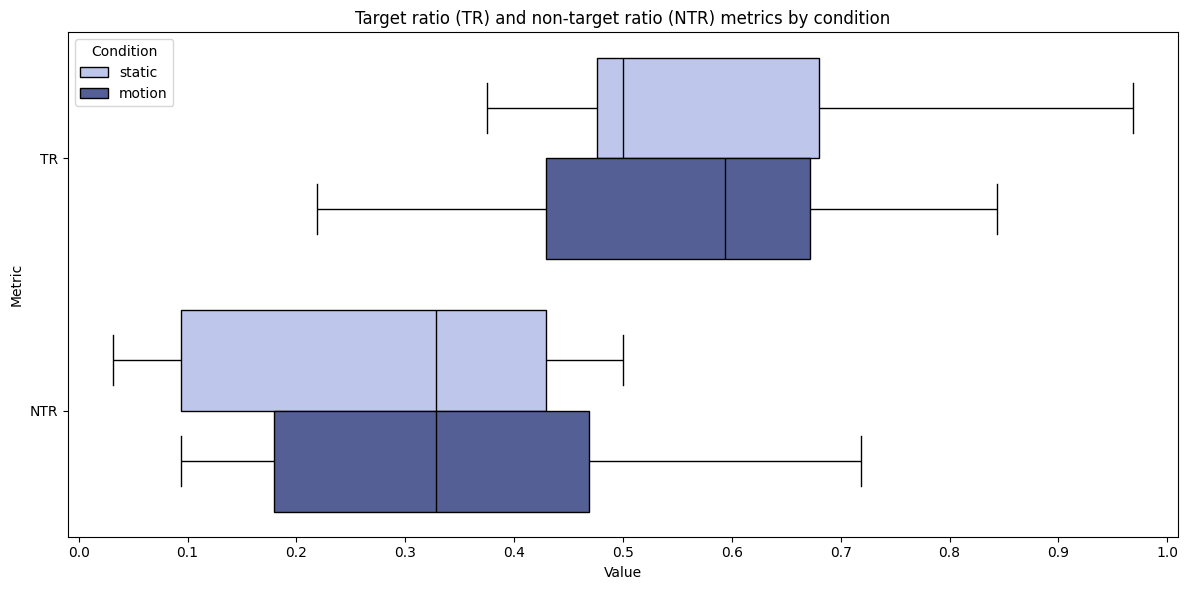

In [12]:

# Melt the DataFrame to long format
melted_df = pd.melt(metrics, id_vars=['SUBJECT', 'Condition'], value_vars=['TR', 'NTR'], var_name='Metric', value_name='Value')

# Create the boxplot
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=melted_df, x='Value', y='Metric', hue='Condition', linewidth=1, linecolor='black', orient='h', ax=ax, palette=["#b8c1f2", "#4959a0"])

# Customize the plot
plt.title("Target ratio (TR) and non-target ratio (NTR) metrics by condition")
plt.xlim(-0.01, 1.01)
plt.xticks(np.arange(0, 1.01, 0.1))
fig.tight_layout()

fig.savefig(f'{plt_folder_name}/4-analysis-boxplot-tr-and-ntr.png')

# Display plot
plt.show()

### Analysis of tr / ntr for group WOLF

In [13]:
# since subjects with odd numbers are group wolf select them
metrics_wolf = metrics.query("SUBJECT % 2 != 0")
metrics_wolf

,SUBJECT,TR,NTR,Condition
0,1,0.43750,0.43750,static
1,1,0.62500,0.34375,motion
2,3,0.50000,0.40625,static
3,3,0.37500,0.62500,motion
4,5,0.84375,0.03125,static
5,5,0.75000,0.09375,motion
6,7,0.37500,0.06250,static
7,7,0.40625,0.15625,motion
8,9,0.96875,0.03125,static
9,9,0.84375,0.15625,motion


In [14]:
stat_tr_dset = metrics_wolf.query("Condition=='static'")
mean_s = stat_tr_dset["TR"].mean()
print("TR(statc) mean: ", dround(mean_s))
mean_s = stat_tr_dset["NTR"].mean()
print("NTR(statc) mean: ", dround(mean_s))

print("")

mot_tr_dset = metrics_wolf.query("Condition=='motion'")
mean_m = mot_tr_dset["TR"].mean()
print("TR(motion) mean: ",dround(mean_m))
mean_m = mot_tr_dset["NTR"].mean()
print("NTR(motion) mean: ",dround(mean_m))

TR(statc) mean:  0.625
NTR(statc) mean:  0.194

TR(motion) mean:  0.6
NTR(motion) mean:  0.275


In [15]:
# TR
# stdev static
N = len(stat_tr_dset["TR"])
d2 = abs(stat_tr_dset["TR"] - mean_s)**2
var = d2.sum() / (N)
std = var**0.5
print("TR stdev(static):", dround(std))

# stdev motion
N = len(mot_tr_dset["TR"])
d2 = abs(mot_tr_dset["TR"] - mean_m)**2
var = d2.sum() / (N)
std = var**0.5
print("TR stdev(motion):", dround(std), "\n")

# NTR
# stdev static
N = len(stat_tr_dset["NTR"])
d2 = abs(stat_tr_dset["NTR"] - mean_s)**2
var = d2.sum() / (N)
std = var**0.5
print("NTR stdev(static):", dround(std))

# stdev motion
N = len(mot_tr_dset["NTR"])
d2 = abs(mot_tr_dset["NTR"] - mean_m)**2
var = d2.sum() / (N)
std = var**0.5
print("NTR stdev(motion):", dround(std))

TR stdev(static): 0.492
TR stdev(motion): 0.374 

NTR stdev(static): 0.187
NTR stdev(motion): 0.194


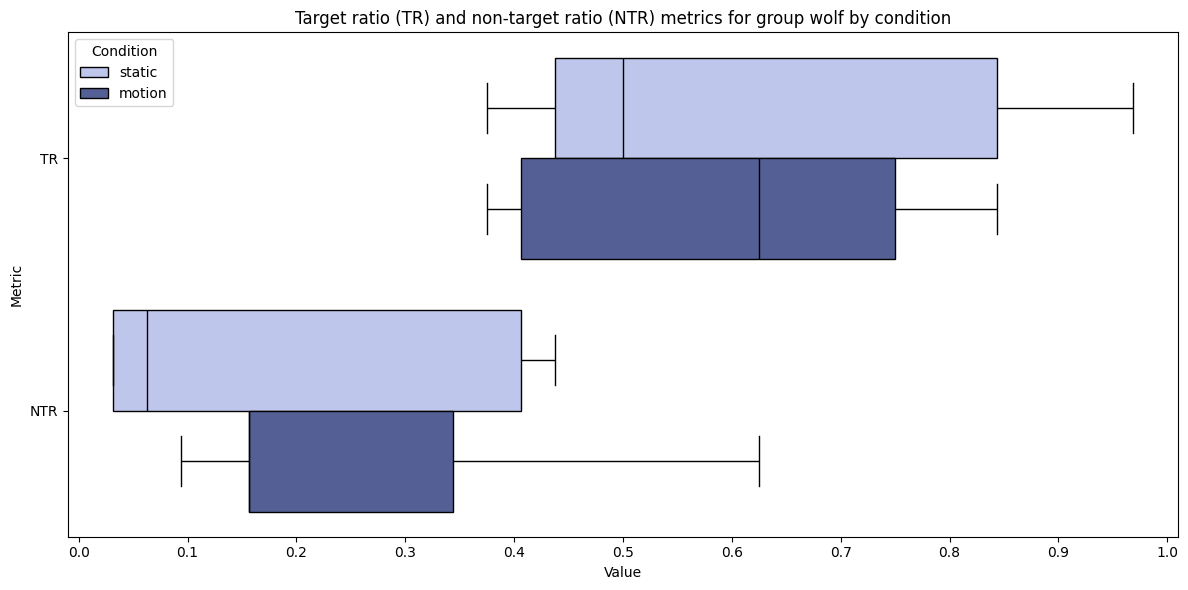

In [16]:
# Melt the DataFrame to long format
melted_df = pd.melt(metrics_wolf, id_vars=['SUBJECT', 'Condition'], value_vars=['TR', 'NTR'], var_name='Metric', value_name='Value')

# Create the boxplot
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=melted_df, x='Value', y='Metric', hue='Condition', linewidth=1, linecolor='black', orient='h', ax=ax, palette=["#b8c1f2", "#4959a0"])

# Customize the plot
plt.title("Target ratio (TR) and non-target ratio (NTR) metrics for group wolf by condition")
plt.xlim(-0.01, 1.01)
plt.xticks(np.arange(0, 1.01, 0.1))
fig.tight_layout()

fig.savefig(f'{plt_folder_name}/4-analysis-boxplot-wolf-tr-and-ntr.png')

# Display plot
plt.show()

### Analysis of tr / ntr for group CHICKEN

In [17]:
# since subjects with even numbers are group wolf select them
metrics_chicken = metrics.query("SUBJECT % 2 == 0")
metrics_chicken

,SUBJECT,TR,NTR,Condition
10,2,0.46875,0.50000,static
11,2,0.50000,0.50000,motion
12,4,0.50000,0.43750,static
13,4,0.21875,0.71875,motion
14,6,0.65625,0.28125,static
15,6,0.68750,0.25000,motion
16,8,0.50000,0.37500,static
17,8,0.62500,0.31250,motion
18,10,0.68750,0.18750,static
19,10,0.56250,0.37500,motion


In [18]:
stat_tr_dset = metrics_chicken.query("Condition=='static'")
mean_s = stat_tr_dset["TR"].mean()
print("TR(statc) mean: ", dround(mean_s))
mean_s = stat_tr_dset["NTR"].mean()
print("NTR(statc) mean: ", dround(mean_s))

print("")

mot_tr_dset = metrics_chicken.query("Condition=='motion'")
mean_m = mot_tr_dset["TR"].mean()
print("TR(motion) mean: ", dround(mean_m))
mean_m = mot_tr_dset["NTR"].mean()
print("NTR(motion) mean: ", dround(mean_m))

TR(statc) mean:  0.562
NTR(statc) mean:  0.356

TR(motion) mean:  0.519
NTR(motion) mean:  0.431


In [19]:
# TR
# stdev static
N = len(stat_tr_dset["TR"])
d2 = abs(stat_tr_dset["TR"] - mean_s)**2
var = d2.sum() / (N)
std = var**0.5
print("TR stdev(static):", dround(std))

# stdev motion
N = len(mot_tr_dset["TR"])
d2 = abs(mot_tr_dset["TR"] - mean_m)**2
var = d2.sum() / (N)
std = var**0.5
print("TR stdev(motion):", dround(std), "\n")

# NTR
# stdev static
N = len(stat_tr_dset["NTR"])
d2 = abs(stat_tr_dset["NTR"] - mean_s)**2
var = d2.sum() / (N)
std = var**0.5
print("NTR stdev(static):", dround(std))

# stdev motion
N = len(mot_tr_dset["NTR"])
d2 = abs(mot_tr_dset["NTR"] - mean_m)**2
var = d2.sum() / (N)
std = var**0.5
print("NTR stdev(motion):", dround(std))

TR stdev(static): 0.225
TR stdev(motion): 0.185 

NTR stdev(static): 0.111
NTR stdev(motion): 0.166


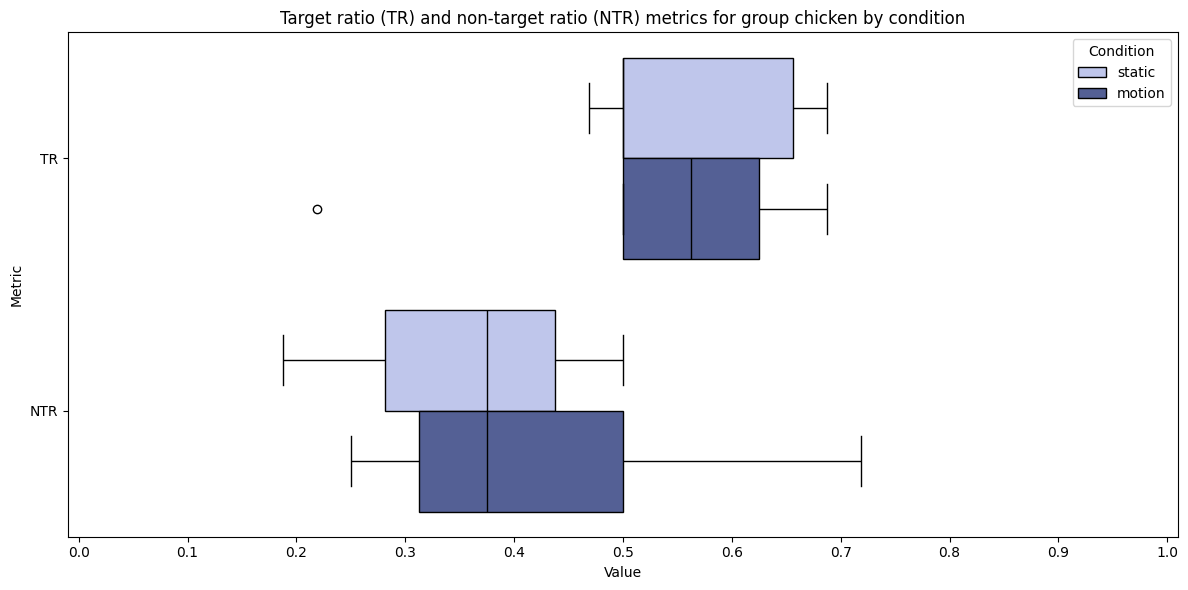

In [20]:
# Melt the DataFrame to long format
melted_df = pd.melt(metrics_chicken, id_vars=['SUBJECT', 'Condition'], value_vars=['TR', 'NTR'], var_name='Metric', value_name='Value')

# Create the boxplot
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=melted_df, x='Value', y='Metric', hue='Condition', linewidth=1, linecolor='black', orient='h', ax=ax, palette=["#b8c1f2", "#4959a0"])

# Customize the plot
plt.title("Target ratio (TR) and non-target ratio (NTR) metrics for group chicken by condition")
plt.xlim(-0.01, 1.01)
plt.xticks(np.arange(0, 1.01, 0.1))
fig.tight_layout()

fig.savefig(f'{plt_folder_name}/4-analysis-boxplot-chicken-tr-and-ntr.png')

# Display plot
plt.show()